In [1]:
import pandas as pd
import numpy as np
import os

import pandas as pd
import numpy as np
from collections import Counter
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.preprocessing import MinMaxScaler
import scipy
from sklearn import metrics

import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import linregress
from scipy import stats
from sklearn.utils import resample

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import permutation_test

def perm_test(group1, group2, n_permutations=10000):
    observed_diff = np.mean(group1) - np.mean(group2)
    
    def statistic(x, y):
        return np.mean(x) - np.mean(y)
    
    result = permutation_test(
        data=(group1, group2),
        statistic=statistic,
        permutation_type='independent',
        vectorized=False,  # importante: no usar vectorized
        n_resamples=n_permutations,
        alternative='two-sided',
        random_state=42
    )
    
    return observed_diff, result.pvalue

def cliffs_delta(x, y):
    n_x = len(x)
    n_y = len(y)
    all_pairs = [(xi, yi) for xi in x for yi in y]
    n_greater = sum(1 for xi, yi in all_pairs if xi > yi)
    n_less = sum(1 for xi, yi in all_pairs if xi < yi)
    
    delta = (n_greater - n_less) / (n_x * n_y)
    return delta

# Función para quitar outliers con IQR
def remove_outliers_iqr(df, col, thres=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - thres * IQR
    upper = Q3 + thres * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

In [3]:
def plot_coef_v01(coef_df_for_plot, results_labels_df_for_plot, df_directions_for_plot):

    df_directions_for_plot = df_directions_for_plot.set_index('index')
    list_coef = list(coef_df_for_plot.index)
    list_coef.remove('_intercept')
    coef_df_for_orig = coef_df_for_plot.copy()
    coef_df_for_plot['coef_sign'] = 0
    
    for i in list_coef:
        sign =  df_directions_for_plot.loc[i, 'coef']
        if(sign<0):
            sign = -1
        else:
            sign = 1
    
        coef_df_for_plot.loc[i, 'coef_sign'] = coef_df_for_plot.loc[i, 'Estimate mean']*sign
    
    coef_df_for_plot['color'] = coef_df_for_plot['coef_sign'].apply(lambda x: 'red' if x > 0 else 'blue')
    
    coef_df_for_plot_sort = coef_df_for_plot.iloc[1::, :].sort_values(by='Estimate mean', ascending=False)
    coef_df_for_plot_sort = coef_df_for_plot_sort[['Estimate mean', 'Estimate std', 'coef_sign', 'color']]
    coef_df_for_plot_sort.reset_index(inplace = True)
    
    #plt.figure(figsize=(3, 4))

    if(coef_df_for_plot_sort.loc[0, 'color'] == 'blue'):
        sns.barplot(x='coef_sign', y='index', data=coef_df_for_plot_sort, hue='color', dodge=False, palette=['royalblue', 'firebrick'], orient='h' ,legend=False)
    else:
        sns.barplot(x='coef_sign', y='index', data=coef_df_for_plot_sort, hue='color', dodge=False, palette=['firebrick', 'royalblue'], orient='h' ,legend=False)
        
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.xlim([-0.3, 0.3])
    plt.xlabel('Features importance')
    plt.ylabel('Features')
    
    r2 = np.round(coef_df_for_orig.loc['_intercept', 'R2'],4)
    f2 = np.round(coef_df_for_orig.loc['_intercept', 'F2'],4)
    rmse = np.round(coef_df_for_orig.loc['_intercept', 'rmse'],4)
    try:
        mde = np.round(coef_df_for_orig.loc['_intercept', 'MDE'],4)
    except:
        mde = 0
    mae = np.round(coef_df_for_orig.loc['_intercept', 'MAE'],4)
    
    y_true = results_labels_df_for_plot['y_labels']
    y_pred = results_labels_df_for_plot['y_pred']
    
    correlacion, p_value = pearsonr(y_true, y_pred)
    
    plt.title(r'$R^{2}$: ' + str(np.round(r2, 4)) + r'   $F^{2}$: ' + str(np.round(f2, 4)) + f'   $r$: {correlacion:.4f}' + f'\nRMSE: {rmse:.4f}' + f'   MDE: {mde:.4f}'+ f'   MAE: {mae:.4f}');
    
    plt.text( -0.20, 7, 'Protected\nFactors', va='center', ha='center', color='blue')
    plt.text( 0.20, 7, 'Risk\nFactors', va='center', ha='center', color='red')

    return coef_df_for_plot_sort

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
import math

# ---------------------------
# Single-color density subplots
# ---------------------------
def plot_density_subplots(y_var, x_list, data, figsize=(5, 5), x_label=None, y_label=None, symmetric=True):
    n = len(x_list)
    ncols = math.ceil(np.sqrt(n))
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]))
    axes = np.array(axes).reshape(-1)

    for i, x_var in enumerate(x_list):
        x = data[x_var]
        y = data[y_var]

        valid = x.notna() & y.notna()
        x = x[valid]
        y = y[valid]

        xy = np.vstack([x, y])
        density = gaussian_kde(xy)(xy)
        sizes = 100 * (density / density.max())

        ax = axes[i]
        ax.scatter(x, y, c=density, s=sizes, cmap='viridis', alpha=0.6)

        slope, intercept, r_value, p_value, _ = linregress(x, y)
        ax.plot(x, intercept + slope * x, color='black')

        r_abs = abs(r_value)
        d_cohen = (2 * r_abs) / np.sqrt(max(1e-12, 1 - r_abs**2))
        p_label = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'

        ax.set_title(x_var, fontsize=10)
        ax.set_xlabel(x_label if x_label is not None else x_var)
        ax.set_ylabel(y_label if y_label is not None else y_var)

        if symmetric:
            max_abs = max(abs(x.min()), abs(x.max()), abs(y.min()), abs(y.max()))
            ax.set_xlim(-max_abs, max_abs)
            ax.set_ylim(-max_abs, max_abs)
            ax.set_xticks([int(-max_abs), 0, int(max_abs)])
            ax.set_yticks([int(-max_abs), 0, int(max_abs)])

        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        ax.text(x_min, y_max, f'd={d_cohen:.2f} r={r_value:.2f}', va='top', ha='left', fontsize=9)
        ax.text(x_max, y_max, p_label, va='top', ha='right', fontsize=11, fontweight='bold')
        ax.text(x_min, y_min, f'n={len(x)}', va='bottom', ha='left', fontsize=8)
        ax.text(x_max, y_min, f'[{x.min():.1f}, {x.max():.1f}]', va='bottom', ha='right', fontsize=8)

    for j in range(len(x_list), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()



def plot_density_subplots_groups(
    y_var,
    x_list,
    data,
    diagnosis_list,
    group_colors=None,
    figsize=(5, 5),
    x_label=None,
    y_label=None,
    symmetric=True
):
    if group_colors is None:
        default_palette = ['#4C78A8', '#F58518', '#54A24B', '#B279A2', '#E45756',
                           '#72B7B2', '#FF9DA6', '#9D755D', '#BAB0AC', '#79706E']
        group_colors = {g: default_palette[i % len(default_palette)] for i, g in enumerate(diagnosis_list)}

    n = len(x_list)
    ncols = math.ceil(np.sqrt(n))
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    for i, x_var in enumerate(x_list):
        x = data[x_var]
        y = data[y_var]
        diag = data['clinical_diagnosis']

        valid = x.notna() & y.notna() & diag.notna()
        x = x[valid]
        y = y[valid]
        diag = diag[valid]

        xy = np.vstack([x, y])
        density = gaussian_kde(xy)(xy)
        sizes = 100 * (density / density.max())

        ax = axes[i]
        ax.scatter(x, y, c=density, s=sizes, cmap='viridis', alpha=0.6)

        ax.set_title(x_var, fontsize=10)
        ax.set_xlabel(x_label if x_label is not None else x_var)
        ax.set_ylabel(y_label if y_label is not None else y_var)

        if symmetric:
            max_abs = max(abs(x.min()), abs(x.max()), abs(y.min()), abs(y.max()))
            ax.set_xlim(-max_abs, max_abs)
            ax.set_ylim(-max_abs, max_abs)
            ax.set_xticks([int(-max_abs), 0, int(max_abs)])
            ax.set_yticks([int(-max_abs), 0, int(max_abs)])

        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        for idx, group in enumerate(diagnosis_list):
            color = group_colors.get(group, 'black')
            mask = (diag == group)
            if mask.sum() > 1:
                xg = x[mask]
                yg = y[mask]
                slope_g, intercept_g, r_value, p_value, _ = linregress(xg, yg)
                r_abs = abs(r_value)
                d_cohen = (2 * r_abs) / np.sqrt(max(1e-12, 1 - r_abs**2))
                p_label = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'

                x_sorted = np.sort(xg)
                ax.plot(x_sorted, intercept_g + slope_g * x_sorted, color=color, linestyle='--', label=group)

                offset = idx * 0.10
                y_up = y_max - offset * (y_max - y_min)
                y_down = y_min + offset * (y_max - y_min)
                bbox_style = dict(facecolor='black', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')

                ax.text(x_min, y_up,   f'd={d_cohen:.2f} r={r_value:.2f}', va='top', ha='left',
                        fontsize=9, color=color, bbox=bbox_style)
                ax.text(x_max, y_up,   p_label, va='top', ha='right',
                        fontsize=11, fontweight='bold', color=color, bbox=bbox_style)
                ax.text(x_min, y_down, f'n={len(xg)}', va='bottom', ha='left',
                        fontsize=8, color=color, bbox=bbox_style)
                ax.text(x_max, y_down, f'[{xg.min():.1f}, {xg.max():.1f}]', va='bottom', ha='right',
                        fontsize=8, color=color, bbox=bbox_style)

    for j in range(len(x_list), len(axes)):
        fig.delaxes(axes[j])

    handles = [plt.Line2D([], [], color=group_colors[g], linestyle='--', label=g) for g in diagnosis_list]
    fig.legend(handles=handles, loc='upper center', ncol=min(len(diagnosis_list), 5), bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout()
    #plt.show()


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress, chi2
import math


def _remove_outliers_xy(x, y, method="mahalanobis", alpha=0.001, whisker=1.5):
    """
    Remove outliers for the x-y pair.
    method:
        - "mahalanobis": elliptical cutoff using chi-square(df=2)
        - "iqr": keep points inside IQR bounds in BOTH x and y
        - anything else: no removal
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if method is None or str(method).lower() == "none":
        keep = np.ones_like(x, dtype=bool)
        return x[keep], y[keep], keep

    if method == "mahalanobis":
        X = np.column_stack([x, y])
        mu = X.mean(axis=0)
        S = np.cov(X, rowvar=False)
        S += np.eye(2) * 1e-9  
        try:
            S_inv = np.linalg.inv(S)
        except np.linalg.LinAlgError:
            S_inv = np.linalg.inv(np.diag(np.diag(S)))
        d2 = np.einsum("ij,jk,ik->i", X - mu, S_inv, X - mu)
        thresh = chi2.ppf(1 - alpha, df=2)
        keep = d2 <= thresh

    elif method == "iqr":
        def iqr_mask(v):
            q1, q3 = np.percentile(v, [25, 75])
            iqr = q3 - q1
            lo = q1 - whisker * iqr
            hi = q3 + whisker * iqr
            return (v >= lo) & (v <= hi)
        keep = iqr_mask(x) & iqr_mask(y)
    else:
        keep = np.ones_like(x, dtype=bool)

    return x[keep], y[keep], keep



def plot_density_subplots_same_x(
    x_var,
    y_list,
    data,
    figsize_per_subplot=(4.2, 4.2),
    x_label=None,
    y_label=None,
    symmetric=True,
    x_lim=None,
    y_lim=None,
    outlier_method="mahalanobis",   # "mahalanobis", "iqr" or None/"none" for no removal
    outlier_alpha=0.001,
    outlier_whisker=1.5
):
    """
    Fixed-X, multi-Y density subplots with optional axis limits.
    - If x_lim and/or y_lim are provided, they are respected.
    - If symmetric=True:
        * with no limits -> make both axes [-max_abs, max_abs]
        * with only one limit given -> expand the other axis to [-max_abs, max_abs]
          using the largest magnitude across provided limits and data ranges.
    - Outlier control:
        * outlier_method="mahalanobis" or "iqr" -> remove outliers
        * outlier_method=None or "none" -> no outlier removal
    """
    n = len(y_list)
    ncols = math.ceil(np.sqrt(n))
    nrows = math.ceil(n / ncols)
    fig_w = figsize_per_subplot[0] * ncols
    fig_h = figsize_per_subplot[1] * nrows

    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h))
    axes = np.array(axes).reshape(-1)

    X_full = data[x_var]

    for i, y_var in enumerate(y_list):
        ax = axes[i]

        Y_full = data[y_var]
        valid = X_full.notna() & Y_full.notna()
        x = X_full[valid].to_numpy()
        y = Y_full[valid].to_numpy()

        x, y, _ = _remove_outliers_xy(
            x, y,
            method=outlier_method,
            alpha=outlier_alpha,
            whisker=outlier_whisker
        )

        if len(x) < 3 or np.all(x == x[0]) or np.all(y == y[0]):
            ax.scatter(x, y, s=12, alpha=0.7)
            ax.set_title(y_var, fontsize=10)
            ax.set_xlabel(x_label if x_label is not None else x_var)
            ax.set_ylabel(y_label if y_label is not None else y_var)

            if x_lim is not None:
                ax.set_xlim(x_lim)
            if y_lim is not None:
                ax.set_ylim(y_lim)
            elif symmetric:
                max_abs = max(
                    (abs(x).max() if x.size else 1),
                    (abs(y).max() if y.size else 1),
                    *(abs(v) for v in (x_lim or (0, 0))),
                    *(abs(v) for v in (y_lim or (0, 0)))
                )
                if max_abs == 0:
                    max_abs = 1.0
                if x_lim is None:
                    ax.set_xlim(-max_abs, max_abs)
                if y_lim is None:
                    ax.set_ylim(-max_abs, max_abs)
            continue

        try:
            xy = np.vstack([x, y])
            density = gaussian_kde(xy)(xy)
            sizes = 100 * (density / density.max())
            ax.scatter(x, y, c=density, s=sizes, cmap='viridis', alpha=0.6)
        except Exception:
            ax.scatter(x, y, s=12, alpha=0.7)

        slope, intercept, r_value, p_value, _ = linregress(x, y)
        xx = np.linspace(x.min(), x.max(), 100)
        ax.plot(xx, intercept + slope * xx, color='black', linewidth=1.25)

        r_abs = abs(r_value)
        d_cohen = (2 * r_abs) / np.sqrt(max(1e-12, 1 - r_abs**2))

        ax.set_title(y_var, fontsize=10)
        ax.set_xlabel(x_label if x_label is not None else x_var)
        ax.set_ylabel(y_label if y_label is not None else y_var)


        if x_lim is not None:
            ax.set_xlim(x_lim)
        if y_lim is not None:
            ax.set_ylim(y_lim)

        if symmetric:
            if x_lim is None and y_lim is None:
                # Full auto symmetric
                max_abs = max(abs(x.min()), abs(x.max()), abs(y.min()), abs(y.max()))
                if max_abs == 0:
                    max_abs = 1.0
                ax.set_xlim(-max_abs, max_abs)
                ax.set_ylim(-max_abs, max_abs)
                ax.set_xticks([-max_abs, 0, max_abs])
                ax.set_yticks([-max_abs, 0, max_abs])
            else:
                # One (or both) limits given: expand the missing one symmetrically
                x_span = x_lim if x_lim is not None else (x.min(), x.max())
                y_span = y_lim if y_lim is not None else (y.min(), y.max())
                max_abs = max(
                    abs(x_span[0]), abs(x_span[1]),
                    abs(y_span[0]), abs(y_span[1])
                )
                if max_abs == 0:
                    max_abs = 1.0
                if x_lim is None:
                    ax.set_xlim(-max_abs, max_abs)
                    ax.set_xticks([-max_abs, 0, max_abs])
                if y_lim is None:
                    ax.set_ylim(-max_abs, max_abs)
                    ax.set_yticks([-max_abs, 0, max_abs])

        p_label = (
            '***' if p_value < 0.001 else
            '**' if p_value < 0.01 else
            '*' if p_value < 0.05 else
            'ns'
        )

        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        ax.text(x_min, y_max, f'd={d_cohen:.2f}  r={r_value:.2f}',
                va='top', ha='left', fontsize=9)
        ax.text(x_max, y_max, p_label,
                va='top', ha='right', fontsize=11, fontweight='bold')
        ax.text(x_min, y_min, f"p = {p_value:.2e}",
                va='bottom', ha='left', fontsize=8)

    for j in range(len(y_list), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    return fig, axes


In [5]:
import numpy as np
import pandas as pd

def flag_group_iqr_outliers(df, value_col, group_col, whisker=1.5):
    """
    Flag outliers in `value_col` using IQR, computed separately within each level of `group_col`.
    Returns:
        outlier_mask: boolean Series indexed as df.index (True = outlier)
        bounds_df: DataFrame with IQR bounds per group (useful for inspection)
    """
    outlier_mask = pd.Series(False, index=df.index)
    bounds = []

    for group, sub in df.groupby(group_col):
        v = sub[value_col].dropna()
        if len(v) < 4:
            # Not enough data to compute a robust IQR
            continue

        q1, q3 = np.percentile(v, [25, 75])
        iqr = q3 - q1
        # If no variability, skip this group
        if iqr == 0:
            continue

        lo = q1 - whisker * iqr
        hi = q3 + whisker * iqr

        mask_sub = (sub[value_col] < lo) | (sub[value_col] > hi)

        outlier_mask.loc[sub.index] = mask_sub
        bounds.append({
            group_col: group,
            "Q1": q1,
            "Q3": q3,
            "IQR": iqr,
            "low_bound": lo,
            "high_bound": hi,
            "n_group": len(sub),
            "n_outliers_group": mask_sub.sum()
        })

    bounds_df = pd.DataFrame(bounds)
    return outlier_mask, bounds_df


def cap_outliers_global(df, value_col="GAP_corrected_M1", group_col="clinical_diagnosis",
                        max_loss=0.10, whisker=1.5):
    """
    Remove outliers in `value_col` by group, but ensuring that no more than `max_loss`
    of all rows are removed in total.

    Steps:
    1) Flag IQR-based outliers within each group.
    2) If total outliers <= max_loss * N -> remove all outliers.
    3) Else -> keep only the most extreme outliers (by distance from IQR bounds)
       up to max_loss * N.

    Returns:
        df_clean: DataFrame without (capped) outliers
        drop_mask: boolean Series with removed rows (True = dropped)
        bounds_df: DataFrame with IQR bounds per group
    """
    N = len(df)
    max_outliers = int(np.floor(max_loss * N))

    # 1) Initial outlier flagging
    outlier_mask, bounds_df = flag_group_iqr_outliers(
        df,
        value_col=value_col,
        group_col=group_col,
        whisker=whisker
    )

    n_outliers = outlier_mask.sum()
    print(f"Total outliers flagged (IQR, grouped by {group_col}): {n_outliers} "
          f"({n_outliers / N:.1%} of all rows)")

    if n_outliers == 0:
        print("No outliers detected. Returning original DataFrame.")
        return df.copy(), pd.Series(False, index=df.index), bounds_df

    # 2) If within allowed limit, drop all outliers
    if n_outliers <= max_outliers:
        print(f"Outliers <= {max_loss:.0%} of total. Removing all flagged outliers.")
        df_clean = df.loc[~outlier_mask].copy()
        drop_mask = outlier_mask
        return df_clean, drop_mask, bounds_df

    # 3) If too many outliers, keep only the most extreme ones up to max_outliers
    print(f"Outliers exceed {max_loss:.0%} of total. "
          f"Keeping only the {max_outliers} most extreme outliers globally.")

    # Compute "extremeness" for each outlier: distance from nearest bound,
    # computed within each group using the same IQR bounds.
    extremeness = pd.Series(0.0, index=df.index)

    for group, sub in df.groupby(group_col):
        # Get bounds for this group
        row = bounds_df[bounds_df[group_col] == group]
        if row.empty:
            continue

        lo = row["low_bound"].values[0]
        hi = row["high_bound"].values[0]

        vals = sub[value_col]

        # Distance outside bounds: 0 if inside
        dist = np.zeros(len(sub), dtype=float)
        dist[vals > hi] = vals[vals > hi] - hi
        dist[vals < lo] = lo - vals[vals < lo]

        extremeness.loc[sub.index] = np.abs(dist)

    # Restrict to initially flagged outliers
    extremeness_outliers = extremeness[outlier_mask]

    # Sort by extremeness (largest first = most extreme)
    sorted_idx = extremeness_outliers.sort_values(ascending=False).index

    # Indices of rows to finally drop
    final_drop_idx = sorted_idx[:max_outliers]

    drop_mask = pd.Series(False, index=df.index)
    drop_mask.loc[final_drop_idx] = True

    df_clean = df.loc[~drop_mask].copy()

    print(f"Final rows dropped: {drop_mask.sum()} "
          f"({drop_mask.sum()/N:.1%} of all rows).")

    return df_clean, drop_mask, bounds_df


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
from sklearn.metrics import r2_score

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / dof)
    return (np.mean(y) - np.mean(x)) / pooled_std

def plot_comparison_scatter(results_labels_df, fig_size=(10, 2.8)):
    fig = plt.figure(figsize=fig_size)

    # Lista de comparaciones: (columna_x, columna_y, etiqueta_y)
    comparisons = [
        ('y_labels', 'y_pred', 'Age predicted'),
        ('y_labels', 'y_pred_M1', 'Age predicted M1'),
        ('y_labels', 'y_pred_M2', 'Age predicted M2'),
        ('y_pred_M1', 'y_pred_M2', 'Age predicted M2')
    ]

    for i, (col_x, col_y, ylabel) in enumerate(comparisons, start=1):
        y_true_all = results_labels_df[col_x]
        y_pred_all = results_labels_df[col_y]

        xy = np.vstack([y_true_all, y_pred_all])
        density = gaussian_kde(xy)(xy)
        sizes = 100 * (density / density.max())

        plt.subplot(1, 4, i)
        plt.scatter(y_true_all, y_pred_all, c=density, s=sizes, cmap='viridis', alpha=0.6)

        # Línea identidad
        min_val = min(y_true_all.min(), y_pred_all.min())
        max_val = max(y_true_all.max(), y_pred_all.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--')

        # Regresión lineal
        slope, intercept, _, _, _ = linregress(y_true_all, y_pred_all)
        plt.plot(y_true_all, intercept + slope * y_true_all, color='black')

        plt.xlabel('Age' if 'y_labels' in col_x else 'Predicted M1')
        plt.ylabel(ylabel)
        r2_ = r2_score(y_true_all, y_pred_all)
        plt.title(f'r = {r2_:.2f}')

    plt.tight_layout()
    #plt.show()


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def remove_outliers_iqr(df, col, iqr_k=1.5):
    s = pd.to_numeric(df[col], errors="coerce")
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - iqr_k * iqr
    high = q3 + iqr_k * iqr
    return df.loc[(s >= low) & (s <= high)].copy()

def cliffs_delta(x, y):
    x = pd.to_numeric(pd.Series(x).dropna(), errors="coerce").dropna().values
    y = pd.to_numeric(pd.Series(y).dropna(), errors="coerce").dropna().values
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return np.nan
    diffs = x[:, None] - y[None, :]
    n_greater = np.sum(diffs > 0)
    n_less = np.sum(diffs < 0)
    return float((n_greater - n_less) / (nx * ny))

def permutation_pvalue(x, y, n_perm=10000, seed=42):
    """Two-sided permutation test for mean difference"""
    rng = np.random.default_rng(seed)
    x = np.array(x.dropna())
    y = np.array(y.dropna())
    if len(x) == 0 or len(y) == 0:
        return np.nan
    obs_diff = np.abs(np.mean(x) - np.mean(y))
    combined = np.concatenate([x, y])
    nx = len(x)
    count = 0
    for _ in range(n_perm):
        rng.shuffle(combined)
        x_perm, y_perm = combined[:nx], combined[nx:]
        diff = np.abs(np.mean(x_perm) - np.mean(y_perm))
        if diff >= obs_diff:
            count += 1
    return count / n_perm

def chunk_list(lst, n):
    """Split list into chunks of size n."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def plot_gap_by_diagnosis_clean_wrap(
    df,
    gap_col,
    diagnosis_list,
    thresholds=(0.1, 0.5, 1.0, 1.5),
    per_line=3,
    title_fontsize=8,
    n_perm=10000
):
    # Build original data by group
    group_data_orig = {}
    for diag in diagnosis_list:
        sub = df[df["clinical_diagnosis"] == diag][[gap_col]].copy()
        sub["Origen"] = diag
        group_data_orig[diag] = sub

    # Unique pairs without repetition
    all_pairs = [(diagnosis_list[i], diagnosis_list[j])
                 for i in range(len(diagnosis_list))
                 for j in range(i+1, len(diagnosis_list))]

    cn_pairs = [(a, b) for (a, b) in all_pairs if a == "CN"]
    other_pairs = [p for p in all_pairs if p not in cn_pairs]

    results_table = []

    fig, axes = plt.subplots(2, 2, figsize=(7.0, 8.0), sharey=True)
    axes = axes.flatten()

    for ax, iqr_k in zip(axes, thresholds):
        group_data_clean = {
            diag: remove_outliers_iqr(group_data_orig[diag], gap_col, iqr_k)
            for diag in diagnosis_list
        }

        cn_lines = []
        for a, b in cn_pairs:
            x = group_data_clean[a][gap_col]
            y = group_data_clean[b][gap_col]
            dval = cliffs_delta(x, y)
            pval = permutation_pvalue(x, y, n_perm=n_perm)
            cn_lines.append(f"{a}-{b}: {dval:.3f}")
            results_table.append([iqr_k, a, b, dval, pval])

        other_lines = []
        for a, b in other_pairs:
            x = group_data_clean[a][gap_col]
            y = group_data_clean[b][gap_col]
            dval = cliffs_delta(x, y)
            pval = permutation_pvalue(x, y, n_perm=n_perm)
            other_lines.append(f"{a}-{b}: {dval:.3f}")
            results_table.append([iqr_k, a, b, dval, pval])

        cn_wrapped = [" | ".join(chunk) for chunk in chunk_list(cn_lines, per_line)]
        other_wrapped = [" | ".join(chunk) for chunk in chunk_list(other_lines, per_line)]

        title_parts = [f"IQR={iqr_k}"] + cn_wrapped + other_wrapped
        ax.set_title("\n".join(title_parts), fontsize=title_fontsize)

        combined = pd.concat([group_data_clean[d] for d in diagnosis_list], ignore_index=True)
        sns.boxplot(data=combined, x="Origen", y=gap_col, order=diagnosis_list, ax=ax)
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel("")
        ax.set_ylabel(gap_col)

    plt.tight_layout()
    results_df = pd.DataFrame(results_table, columns=["IQR_k", "Group1", "Group2", "CliffsDelta", "p_value"])
    return fig, axes, results_df


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, t, norm, chi2

# ---------- helpers ----------
def slope_ci(x, y, alpha=0.01):
    """OLS slope and (1-alpha) CI."""
    n = len(x)
    lr = linregress(x, y)
    y_pred = lr.intercept + lr.slope * x
    residuals = y - y_pred
    dof = max(1, n - 2)
    s_err = np.sqrt(np.sum(residuals**2) / dof)
    sx = np.sum((x - np.mean(x))**2)
    se_beta = s_err / np.sqrt(max(1e-12, sx))
    t_val = t.ppf(1 - alpha/2, df=dof)
    ci_low = lr.slope - t_val * se_beta
    ci_high = lr.slope + t_val * se_beta
    return lr.slope, ci_low, ci_high, lr.rvalue, lr.pvalue

def r_ci(r, n, alpha=0.01):
    """Fisher z CI for Pearson r."""
    if n <= 3 or np.isnan(r):
        return r, np.nan, np.nan
    r = float(np.clip(r, -0.999999, 0.999999))
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha/2)
    lo, hi = z - z_crit*se, z + z_crit*se
    return r, np.tanh(lo), np.tanh(hi)

def _remove_outliers_xy(x, y, method="mahalanobis", alpha=0.001, whisker=1.5):
    """
    Remove outliers for an (x,y) pair.
    - "mahalanobis": elliptical cutoff via chi-square(df=2)
    - "iqr": keep inside univariate IQR bounds on BOTH x and y
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if len(x) < 3:
        keep = np.ones_like(x, dtype=bool)
        return x[keep], y[keep], keep

    if method == "mahalanobis":
        X = np.column_stack([x, y])
        mu = X.mean(axis=0)
        S = np.cov(X, rowvar=False)
        S += np.eye(2) * 1e-9  # numerical stability
        try:
            S_inv = np.linalg.inv(S)
        except np.linalg.LinAlgError:
            S_inv = np.linalg.inv(np.diag(np.diag(S)))
        d2 = np.einsum("ij,jk,ik->i", X - mu, S_inv, X - mu)
        thresh = chi2.ppf(1 - alpha, df=2)
        keep = d2 <= thresh

    elif method == "iqr":
        def iqr_mask(v):
            q1, q3 = np.percentile(v, [25, 75])
            iqr = q3 - q1
            lo = q1 - whisker * iqr
            hi = q3 + whisker * iqr
            return (v >= lo) & (v <= hi)
        keep = iqr_mask(x) & iqr_mask(y)

    else:
        keep = np.ones_like(x, dtype=bool)

    return x[keep], y[keep], keep

# ---------- main ----------
def plot_slope_r_with_ci_same_x(
    x_var,
    y_list,
    data,
    diagnosis_list,
    figsize=(7, 5),
    alpha=0.01,
    remove_outliers=False,
    outlier_method="mahalanobis",
    outlier_alpha=0.001,
    outlier_whisker=1.5
):
    """
    Fixed X, multiple Y.
    For each Y and each group:
      - optionally remove outliers on (X,Y) within the group
      - compute slope ± CI and r ± CI
      - plot two columns: left = slope CI, right = r CI
    """
    results = []
    slope_all, r_all = [], []

    X_full = data[x_var]
    diag_full = data["clinical_diagnosis"]

    # Collect global ranges from CLEANED stats
    for y_var in y_list:
        Y_full = data[y_var]
        valid = X_full.notna() & Y_full.notna() & diag_full.notna()
        x_all = X_full[valid].to_numpy()
        y_all = Y_full[valid].to_numpy()
        d_all = diag_full[valid].to_numpy()

        for group in diagnosis_list:
            mask = (d_all == group)
            if np.sum(mask) > 2:
                x_g_raw = x_all[mask]
                y_g_raw = y_all[mask]
                n_raw = int(len(x_g_raw))

                if remove_outliers:
                    x_g, y_g, keep = _remove_outliers_xy(
                        x_g_raw, y_g_raw,
                        method=outlier_method,
                        alpha=outlier_alpha,
                        whisker=outlier_whisker
                    )
                else:
                    x_g, y_g = x_g_raw, y_g_raw
                    keep = np.ones_like(x_g_raw, dtype=bool)

                n_clean = int(len(x_g))
                if n_clean > 2 and np.std(x_g) > 0 and np.std(y_g) > 0:
                    slope, lo, hi, r_val, p_val = slope_ci(x_g, y_g, alpha=alpha)
                    _, r_lo, r_hi = r_ci(r_val, n_clean, alpha=alpha)

                    slope_all.extend([slope, lo, hi])
                    r_all.extend([r_val, r_lo, r_hi])

                    results.append({
                        "y_var": y_var,
                        "x_var": x_var,
                        "Group": group,
                        "n_raw": n_raw,
                        "n_clean": n_clean,
                        "removed_pct": 0.0 if n_raw == 0 else 100.0 * (n_raw - n_clean) / n_raw,
                        "slope": slope,
                        "slope_CI_low": lo,
                        "slope_CI_high": hi,
                        "r": r_val,
                        "r_CI_low": r_lo,
                        "r_CI_high": r_hi,
                        "p_value": p_val
                    })

    results_df = pd.DataFrame(results)

    # Axis ranges
    if len(slope_all) == 0:
        slope_min, slope_max = -1, 1
        r_min, r_max = -1, 1
    else:
        slope_min, slope_max = np.nanmin(slope_all), np.nanmax(slope_all)
        r_min, r_max = np.nanmin(r_all), np.nanmax(r_all)

    # Plot: one row per Y, two columns
    n = len(y_list)
    fig, axes = plt.subplots(n, 2, figsize=(figsize[0]*2, figsize[1]*n), squeeze=False)

    ci_label = f"{int((1 - alpha) * 100)}% CI"

    for i, y_var in enumerate(y_list):
        df_sub = results_df[results_df["y_var"] == y_var].copy()
        if df_sub.empty:
            axes[i, 0].set_visible(False)
            axes[i, 1].set_visible(False)
            continue

        df_sub["Group"] = pd.Categorical(df_sub["Group"], categories=diagnosis_list, ordered=True)
        df_sub = df_sub.sort_values("Group")

        # ----- slope subplot -----
        ax_slope = axes[i, 0]
        yerr_slope = np.vstack([
            df_sub["slope"] - df_sub["slope_CI_low"],
            df_sub["slope_CI_high"] - df_sub["slope"]
        ])
        ax_slope.errorbar(df_sub["Group"], df_sub["slope"], yerr=yerr_slope, fmt='o', capsize=4)
        ax_slope.set_title(f"{y_var} – slope ({ci_label})")
        ax_slope.axhline(0, color="gray", linestyle="--")
        ax_slope.set_ylim(slope_min, slope_max)

        # annotate p and sample sizes
        for j, (grp, slope_val, pval, n_raw, n_clean, rem) in enumerate(
            zip(df_sub["Group"], df_sub["slope"], df_sub["p_value"], df_sub["n_raw"], df_sub["n_clean"], df_sub["removed_pct"])
        ):
            ax_slope.text(j, slope_val, f"p={pval:.3f}\nN={n_clean} (raw {n_raw}, -{rem:.1f}%)",
                          ha='center', va='bottom', fontsize=8, color="blue")

        # ----- r subplot -----
        ax_r = axes[i, 1]
        yerr_r = np.vstack([
            df_sub["r"] - df_sub["r_CI_low"],
            df_sub["r_CI_high"] - df_sub["r"]
        ])
        ax_r.errorbar(df_sub["Group"], df_sub["r"], yerr=yerr_r, fmt='o', capsize=4, color="orange")
        ax_r.set_title(f"{y_var} – r ({ci_label})")
        ax_r.axhline(0, color="gray", linestyle="--")
        ax_r.set_ylim(min(-1.0, r_min - 0.05), max(1.0, r_max + 0.05))

        for j, (grp, rval, pval, n_raw, n_clean, rem) in enumerate(
            zip(df_sub["Group"], df_sub["r"], df_sub["p_value"], df_sub["n_raw"], df_sub["n_clean"], df_sub["removed_pct"])
        ):
            ax_r.text(j, rval, f"p={pval:.5f}\nN={n_clean} (raw {n_raw}, -{rem:.1f}%)",
                      ha='center', va='bottom', fontsize=8, color="red")

    plt.tight_layout()
    return fig, axes, results_df


## Boxplot

### Without augmented data

In [26]:
df_boxplot =  pd.read_excel('../Data/SAGs.xlsx')

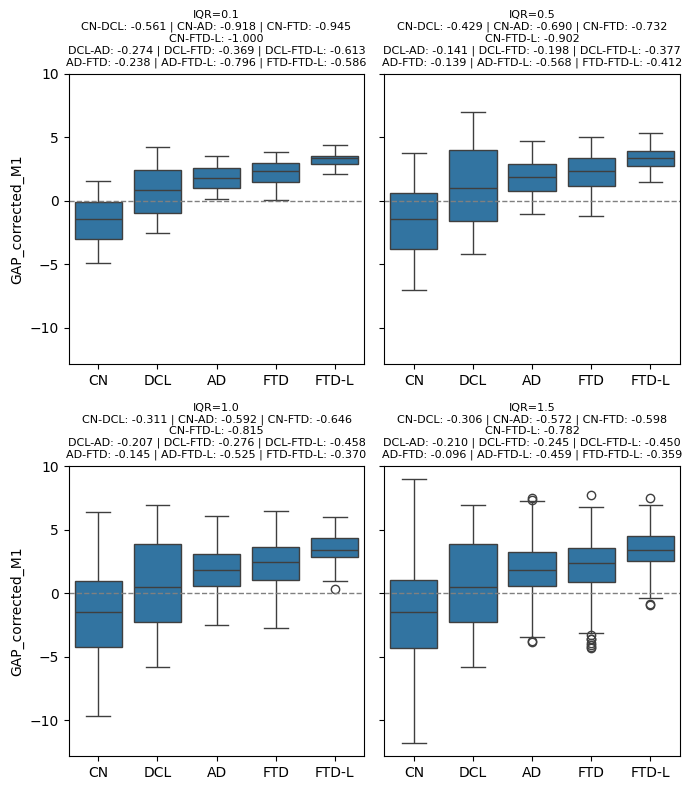

In [27]:
diagnosis_list = ["CN", "DCL", "AD", "FTD", "FTD-L"]

a = plot_gap_by_diagnosis_clean_wrap(
    df_boxplot,
    gap_col="GAP_corrected_M1",
    diagnosis_list=diagnosis_list
);

In [28]:
df_boxplot =  pd.read_excel('../Data/SAGs_data_augmented.xlsx')

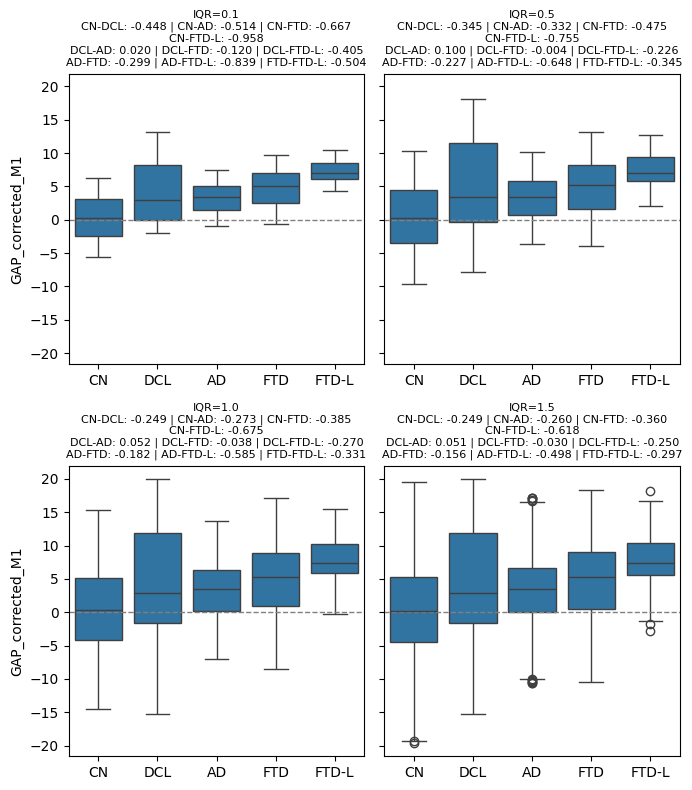

In [29]:
diagnosis_list = ["CN", "DCL", "AD", "FTD", "FTD-L"]

a = plot_gap_by_diagnosis_clean_wrap(
    df_boxplot,
    gap_col="GAP_corrected_M1",
    diagnosis_list=diagnosis_list
);

## Feature Importance

In [ ]:

df_feat_imp =  pd.read_excel('../Data/feature_importances.xlsx')
perm_importance_avg =  pd.read_excel('../Data/perm_importance_avg.xlsx')

perm_importance_avg = perm_importance_avg.set_index(perm_importance_avg.columns[0])[perm_importance_avg.columns[1]].astype(float)
perm_importance_avg.name = None  

In [ ]:
df_feat_imp['GAP_bin'] = np.where(df_feat_imp['GAP_corrected_M1'] <= 0, 0, 1)

from scipy.stats import pointbiserialr
selected_hgb = ['concreteness',
       'granularity_extraction', 'psycholinguistic_objective',
       'pitch_analysis', 'sentiment_analysis', 'talking_intervals',
       'verbosity']
results = []
for col in selected_hgb:
    corr, pval = pointbiserialr(df_feat_imp['GAP_bin'], df_feat_imp[col])
    direction = 'Positive' if corr > 0 else 'Negative'
    results.append({'Variable': col, 'Correlation': corr, 'Direction': direction, 'p-value': pval})


dir_df = pd.DataFrame(results)
dir_df;

In [ ]:
combined_df = pd.DataFrame({
    'Importance': perm_importance_avg
}).reset_index().rename(columns={'Unnamed: 0':'Variable'})


combined_df = combined_df.merge(dir_df, on='Variable', how='inner')
combined_df = combined_df.rename(columns={'Unnamed: 0':'Variable'})

In [ ]:


combined_df['SignedImportance'] = np.where(
    combined_df['Direction'] == 'Positive',
    combined_df['Importance'],
    -combined_df['Importance']
)

combined_df = combined_df.reindex(combined_df['Importance'].abs().sort_values(ascending=True).index)

colors = combined_df['SignedImportance'].apply(lambda x: 'tomato' if x > 0 else 'green')
alphas = combined_df['p-value'].apply(lambda p: 0.4 if p > 0.05 else 1.0)  # transparente si p < 0.05

plt.figure(figsize=(4, 3))
for idx, row in combined_df.iterrows():
    plt.barh(row['Variable'], row['SignedImportance'], 
             color='tomato' if row['SignedImportance'] > 0 else 'green',
             alpha=0.4 if row['p-value'] > 0.05 else 1.0)

plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.xlim([-0.3,0.3])
plt.tight_layout()

## SAGs vs BAGs

In [12]:
df_BAGS =  pd.read_excel('../Data/SAGvsBAG.xlsx')

In [ ]:
df_BAGS_clean, drop_mask, bounds = cap_outliers_global(
    df_BAGS,
    value_col="GAP_corrected_M1",
    group_col="clinical_diagnosis",
    max_loss=0.10,  
    whisker=1.5      
)


In [ ]:
y_list=['BAG_structural', 'BAG_functional', 'BAG_combined']

fig, axes = plot_density_subplots_same_x(
    x_var="GAP_corrected_M1",
    y_list=y_list,
    data=df_BAGS_clean,
    figsize_per_subplot=(5.5/2, 5./2),
    symmetric=True,
    outlier_method="None"
)


In [ ]:
diagnosis_list = ["CN", "DCL", "AD", "FTD", "FTD-L"]
group_colors = {"CN":"#7f7f7f","DCL":"#1f77b4","AD":"#ff7f0e","FTD":"#2ca02c","FTD-L":"#9467bd"}

fig, axes, df_stats = plot_slope_r_with_ci_same_x(
     x_var="GAP_corrected_M1",
     y_list=['BAG_functional', 'BAG_structural', 'BAG_combined'],
     data=df_BAGS_clean,
     diagnosis_list=diagnosis_list,
     alpha=0.05,
    remove_outliers=False,
    figsize=(5.8, 2.2),
 )

## SAG vs Epi

In [ ]:
df_BAG_epi =  pd.read_excel('../Data/SAGvsEpi.xlsx')

In [ ]:
df_BAG_epi_clean, drop_mask, bounds = cap_outliers_global(
    df_BAG_epi,
    value_col="GAP_corrected_M1",
    group_col="clinical_diagnosis",
    max_loss=0.10,
    whisker=1.5   
)


In [ ]:
y_list= ['BAG_Retroclock', 'BAG_OMICmAge', 'BAG_GrimAgeV2']


fig, axes = plot_density_subplots_same_x(
    x_var="GAP_corrected_M1",
    y_list=y_list,
    data=df_BAG_epi_clean,
    figsize_per_subplot=(5.5/2, 5./2),
    symmetric=False,
    outlier_method="None",
    #outlier_whisker=3.5,
    y_lim = [-25, 25],
    x_lim = [-40, 40]
)

In [ ]:
diagnosis_list = ["CN", "DCL", "AD", "FTD", "FTD-L"]
group_colors = {"CN":"#7f7f7f","DCL":"#1f77b4","AD":"#ff7f0e","FTD":"#2ca02c","FTD-L":"#9467bd"}

fig, axes, df_stats = plot_slope_r_with_ci_same_x(
     x_var="GAP_corrected_M1",
     y_list=y_list,
     data=df_BAG_epi_clean,
     diagnosis_list=diagnosis_list,
     alpha=0.05,
    remove_outliers=False,
    figsize=(5.8, 2.2),
 )

## SAGs vs clinical/cognitive

In [ ]:
df_BAG_neuro =  pd.read_excel('../Data/SAGvsClinical-cognitive.xlsx')

In [ ]:
df_BAG_neuro_clean, drop_mask, bounds = cap_outliers_global(
    df_BAG_neuro,
    value_col="GAP_corrected_M1",
    group_col="clinical_diagnosis",
    max_loss=0.10,   
    whisker=3.5      
)


#### Clinical/cognitive individuals comparision

In [ ]:
y_list = ['cog_benson',
 'cog_benson_delay',
 'cog_benson_recog',
 'cog_craft_verb',
 'cog_craft_verb_delayed',
 'cog_digits_backward_span',
 'cog_digits_backward_total',
 'cog_digits_forward_span',
 'cog_digits_forward_total',
 'cog_mint_total',
 'cog_tmt_b_corr',
 'mmse_total',
 't_adlq_adv_score5',
 't_adlq_bas_score5',
 't_adlq_ins_score5',
 'udsfaq_total']

In [ ]:
diagnosis_list = ["CN", "DCL", "AD", "FTD", "FTD-L"]
group_colors = {"CN":"#7f7f7f","DCL":"#1f77b4","AD":"#ff7f0e","FTD":"#2ca02c","FTD-L":"#9467bd"}

y_list

fig, axes, df_stats = plot_slope_r_with_ci_same_x(
     x_var="GAP_corrected_M1",
     y_list=y_list,
     data= df_BAG_neuro_clean,
     diagnosis_list=diagnosis_list,
     alpha=0.05,
    remove_outliers=False,
    figsize=(5.8, 2.2),
 )

#### Clinical/cognitive categories comparision

In [ ]:
y_list=['Linguistic', 'Non_Linguistic']


fig, axes = plot_density_subplots_same_x(
    x_var="GAP_corrected_M1",
    y_list=y_list,
    data=df_BAG_neuro_clean,
    figsize_per_subplot=(5.3/2, 5.3/2),
    symmetric=False,
    outlier_method="None",
    x_lim = [-40, 40]
)

In [ ]:
diagnosis_list = ["CN", "DCL", "AD", "FTD", "FTD-L"]
group_colors = {"CN":"#7f7f7f","DCL":"#1f77b4","AD":"#ff7f0e","FTD":"#2ca02c","FTD-L":"#9467bd"}

y_list=['Linguistic', 'Non_Linguistic']

fig, axes, df_stats = plot_slope_r_with_ci_same_x(
     x_var="GAP_corrected_M1",
     y_list=y_list,
     data= df_BAG_neuro_clean,
     diagnosis_list=diagnosis_list,
     alpha=0.05,
    remove_outliers=False,
    figsize=(5.8, 2.2),
 )


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from scipy.stats import linregress, mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt

# === USER PARAMS ===
y_col  = "GAP_corrected_M1"
x1_col = "Linguistic"
x2_col = "Non_Linguistic"
n_iter = 20
train_size = 0.8
seed_ling = 42          # independent random seeds (not paired)
seed_nonling = 2025

# --- 0) Build a consistent sample (no NaNs across all three columns)
cols_needed = [y_col, x1_col, x2_col]
df_base = df_BAG_neuro[cols_needed].dropna().reset_index(drop=True)
if len(df_base) < 10:
    raise ValueError("Not enough rows after dropping NaNs. Check your data.")

X1 = df_base[x1_col].values.astype(float)  # 1D for linregress
X2 = df_base[x2_col].values.astype(float)
y  = df_base[y_col ].values.astype(float)

def safe_linregress_r(xv, yv):
    # Guard against zero variance
    if np.std(xv) == 0 or np.std(yv) == 0:
        return np.nan
    slope, intercept, r_value, p_value, _ = linregress(xv, yv)
    return r_value

# --- 1) Independent random partitions for each predictor (NOT paired)
splitter_ling = ShuffleSplit(n_splits=n_iter, train_size=train_size, random_state=seed_ling)
splitter_nonl = ShuffleSplit(n_splits=n_iter, train_size=train_size, random_state=seed_nonling)

r_linguistic_train = []
for train_idx, _ in splitter_ling.split(df_base):
    x_tr = X1[train_idx]
    y_tr = y[train_idx]
    r_linguistic_train.append(safe_linregress_r(x_tr, y_tr))

r_nonling_train = []
for train_idx, _ in splitter_nonl.split(df_base):
    x_tr = X2[train_idx]
    y_tr = y[train_idx]
    r_nonling_train.append(safe_linregress_r(x_tr, y_tr))

# Convert to arrays and drop NaNs
r_linguistic_train = np.array(r_linguistic_train, dtype=float)
r_nonling_train    = np.array(r_nonling_train, dtype=float)
r_linguistic_train = r_linguistic_train[np.isfinite(r_linguistic_train)]
r_nonling_train    = r_nonling_train[np.isfinite(r_nonling_train)]


import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt

def iqr_filter(x, k=1.5):
    """Return filtered values and a boolean mask of kept elements."""
    x = np.asarray(x, dtype=float)
    q1, q3 = np.nanpercentile(x, [25, 75])
    iqr = q3 - q1
    low, high = q1 - k * iqr, q3 + k * iqr
    keep = (x >= low) & (x <= high) & np.isfinite(x)
    return x[keep], keep

# Remove outliers independently in each group
r_ling_no, keep_ling = iqr_filter(r_linguistic_train, k=1.5)
r_nonl_no, keep_nonl = iqr_filter(r_nonling_train,    k=1.5)

print(f"Removed outliers (Linguistic): {len(r_linguistic_train) - len(r_ling_no)}")
print(f"Removed outliers (Non_Linguistic): {len(r_nonling_train) - len(r_nonl_no)}")

# Independent tests on outlier-removed samples
mw_stat, mw_p = mannwhitneyu(r_ling_no, r_nonl_no, alternative='two-sided')
t_stat, t_p   = ttest_ind(r_ling_no, r_nonl_no, equal_var=False)

print("Mann–Whitney U (independent, no outliers):")
print(f"  U={mw_stat:.3f}, p-value={mw_p:.6g}")
print("Welch's t-test (independent, no outliers):")
print(f"  t={t_stat:.3f}, p-value={t_p:.6g}")

print(f"Mean r (Linguistic, no outliers)     = {r_ling_no.mean():.3f} ± {r_ling_no.std(ddof=1):.3f}")
print(f"Mean r (Non_Linguistic, no outliers) = {r_nonl_no.mean():.3f} ± {r_nonl_no.std(ddof=1):.3f}")

# Boxplot without outliers
plt.figure(figsize=(4, 3))
plt.boxplot([r_ling_no, r_nonl_no],
            labels=["Linguistic (train r)", "Non_Linguistic (train r)"],
            showmeans=True)
plt.ylabel("Pearson r on training partitions (linregress)")
plt.title("Independent partitions: r_train (outliers removed by IQR)")
plt.tight_layout()


In [ ]:
y_list=['Functional ability',
 'Executive',
 'Global_Cognition',
 'Memory',
 'Episodic memory',
 'Visual memory']


fig, axes = plot_density_subplots_same_x(
    x_var="GAP_corrected_M1",
    y_list=y_list,
    data=df_BAG_neuro_clean,
    figsize_per_subplot=(5.3/2, 5.3/2),
    symmetric=False,
    outlier_method="None",
    x_lim = [-40, 40]
)

In [ ]:
diagnosis_list = ["CN", "DCL", "AD", "FTD", "FTD-L"]
group_colors = {"CN":"#7f7f7f","DCL":"#1f77b4","AD":"#ff7f0e","FTD":"#2ca02c","FTD-L":"#9467bd"}

y_list=['Functional ability',
 'Executive',
 'Global_Cognition',
 'Memory',
 'Episodic memory',
 'Visual memory']

fig, axes, df_stats = plot_slope_r_with_ci_same_x(
     x_var="GAP_corrected_M1",
     y_list=y_list,
     data=df_BAG_neuro_clean,
     diagnosis_list=diagnosis_list,
     alpha=0.05,
    remove_outliers=False,
    figsize=(5.8, 2.2),
 )

## SA vs p-Tau217

In [ ]:
df_BAG_atn =  pd.read_excel('../Data/SAGsvsPlasma.xlsx')

In [ ]:
df_BAG_atn_clean, drop_mask, bounds = cap_outliers_global(
    df_BAG_atn,
    value_col="GAP_corrected_M1",
    group_col="clinical_diagnosis",
    max_loss=0.10,   
    whisker=1.0      
)


In [ ]:
y_list=['p-tau217']


fig, axes = plot_density_subplots_same_x(
    x_var="GAP_corrected_M1",
    y_list=y_list,
    data=df_BAG_atn_clean,
    figsize_per_subplot=(5.7/2, 5.3/2),
    symmetric=False,
    outlier_method="None",
    y_lim = [0, 1.75],
    x_lim = [-40, 40]
)

In [ ]:
diagnosis_list = ["CN", "DCL", "AD", "FTD", "FTD-L"]
group_colors = {"CN":"#7f7f7f","DCL":"#1f77b4","AD":"#ff7f0e","FTD":"#2ca02c","FTD-L":"#9467bd"}

y_list=['p-tau217']

fig, axes, df_stats = plot_slope_r_with_ci_same_x(
     x_var = "GAP_corrected_M1",
     y_list = y_list,
     data = df_BAG_atn_clean,
     diagnosis_list=diagnosis_list,
     alpha=0.05,
    remove_outliers=False,
    figsize=(5.8, 2.2),
 )


## SAGsvsSocialExposome

In [ ]:
df_BAG_ses =  pd.read_excel('../Data/SAGsvsSocial-exposome.xlsx')

In [ ]:
df_BAG_ses_clean, drop_mask, bounds = cap_outliers_global(
    df_BAG_ses,
    value_col="GAP_corrected_M1",
    group_col="clinical_diagnosis",
    max_loss=0.10, 
    whisker=2.5     
)



In [ ]:
fig, axes = plot_density_subplots_same_x(
    x_var="GAP_corrected_M1",
    y_list=['SDH_factor'],
    data=df_BAG_ses_clean,
    figsize_per_subplot=(5.7/2, 5.3/2),
    symmetric=False,
    outlier_method="iqr",
    outlier_whisker=3.5,
    x_lim = [-40, 40]
)


In [ ]:
diagnosis_list = ["CN", "DCL", "AD", "FTD", "FTD-L"]
group_colors = {"CN":"#7f7f7f","DCL":"#1f77b4","AD":"#ff7f0e","FTD":"#2ca02c","FTD-L":"#9467bd"}

y_list=['SDH_factor']

fig, axes, df_stats = plot_slope_r_with_ci_same_x(
     x_var="GAP_corrected_M1",
     y_list=y_list,
     data=df_BAG_ses_clean,
     diagnosis_list=diagnosis_list,
     alpha=0.05,
    remove_outliers=True,
    outlier_alpha=0.001,
    outlier_whisker=100,
    figsize=(5.8, 2.2),
 )